In [4]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import PuOr
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from pycebox.ice import ice, ice_plot
import pandas as pd

# Скачать данные
# Download data

In [65]:
from io import BytesIO
from zipfile import ZipFile
import pandas
import requests

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
filename = requests.get(url).content
z = ZipFile( BytesIO(filename), 'r' )
for item in z.namelist():
    print("File in zip: "+ item)

File in zip: Readme.txt
File in zip: day.csv
File in zip: hour.csv


In [66]:
data = pd.read_csv(z.open("day.csv"))
data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [67]:
data.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

# select features
# выберать признаки

In [68]:
data_X={'season': data.season, 
        'month': data.mnth,
        'holiday': data.holiday,
        'weekday': data.weekday, 
        'workingday': data.workingday, 
        'weathersit':data.weathersit,
        'temperature': data.temp, 
        'humidity': data.hum, 
        'windspeed': data.windspeed
        }
X = pd.DataFrame(data = data_X)

y = data.cnt

# # удалить среднее значение
# # substract mean
# y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [69]:
X_train.columns

Index(['season', 'month', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temperature', 'humidity', 'windspeed'],
      dtype='object')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 720x576 with 0 Axes>

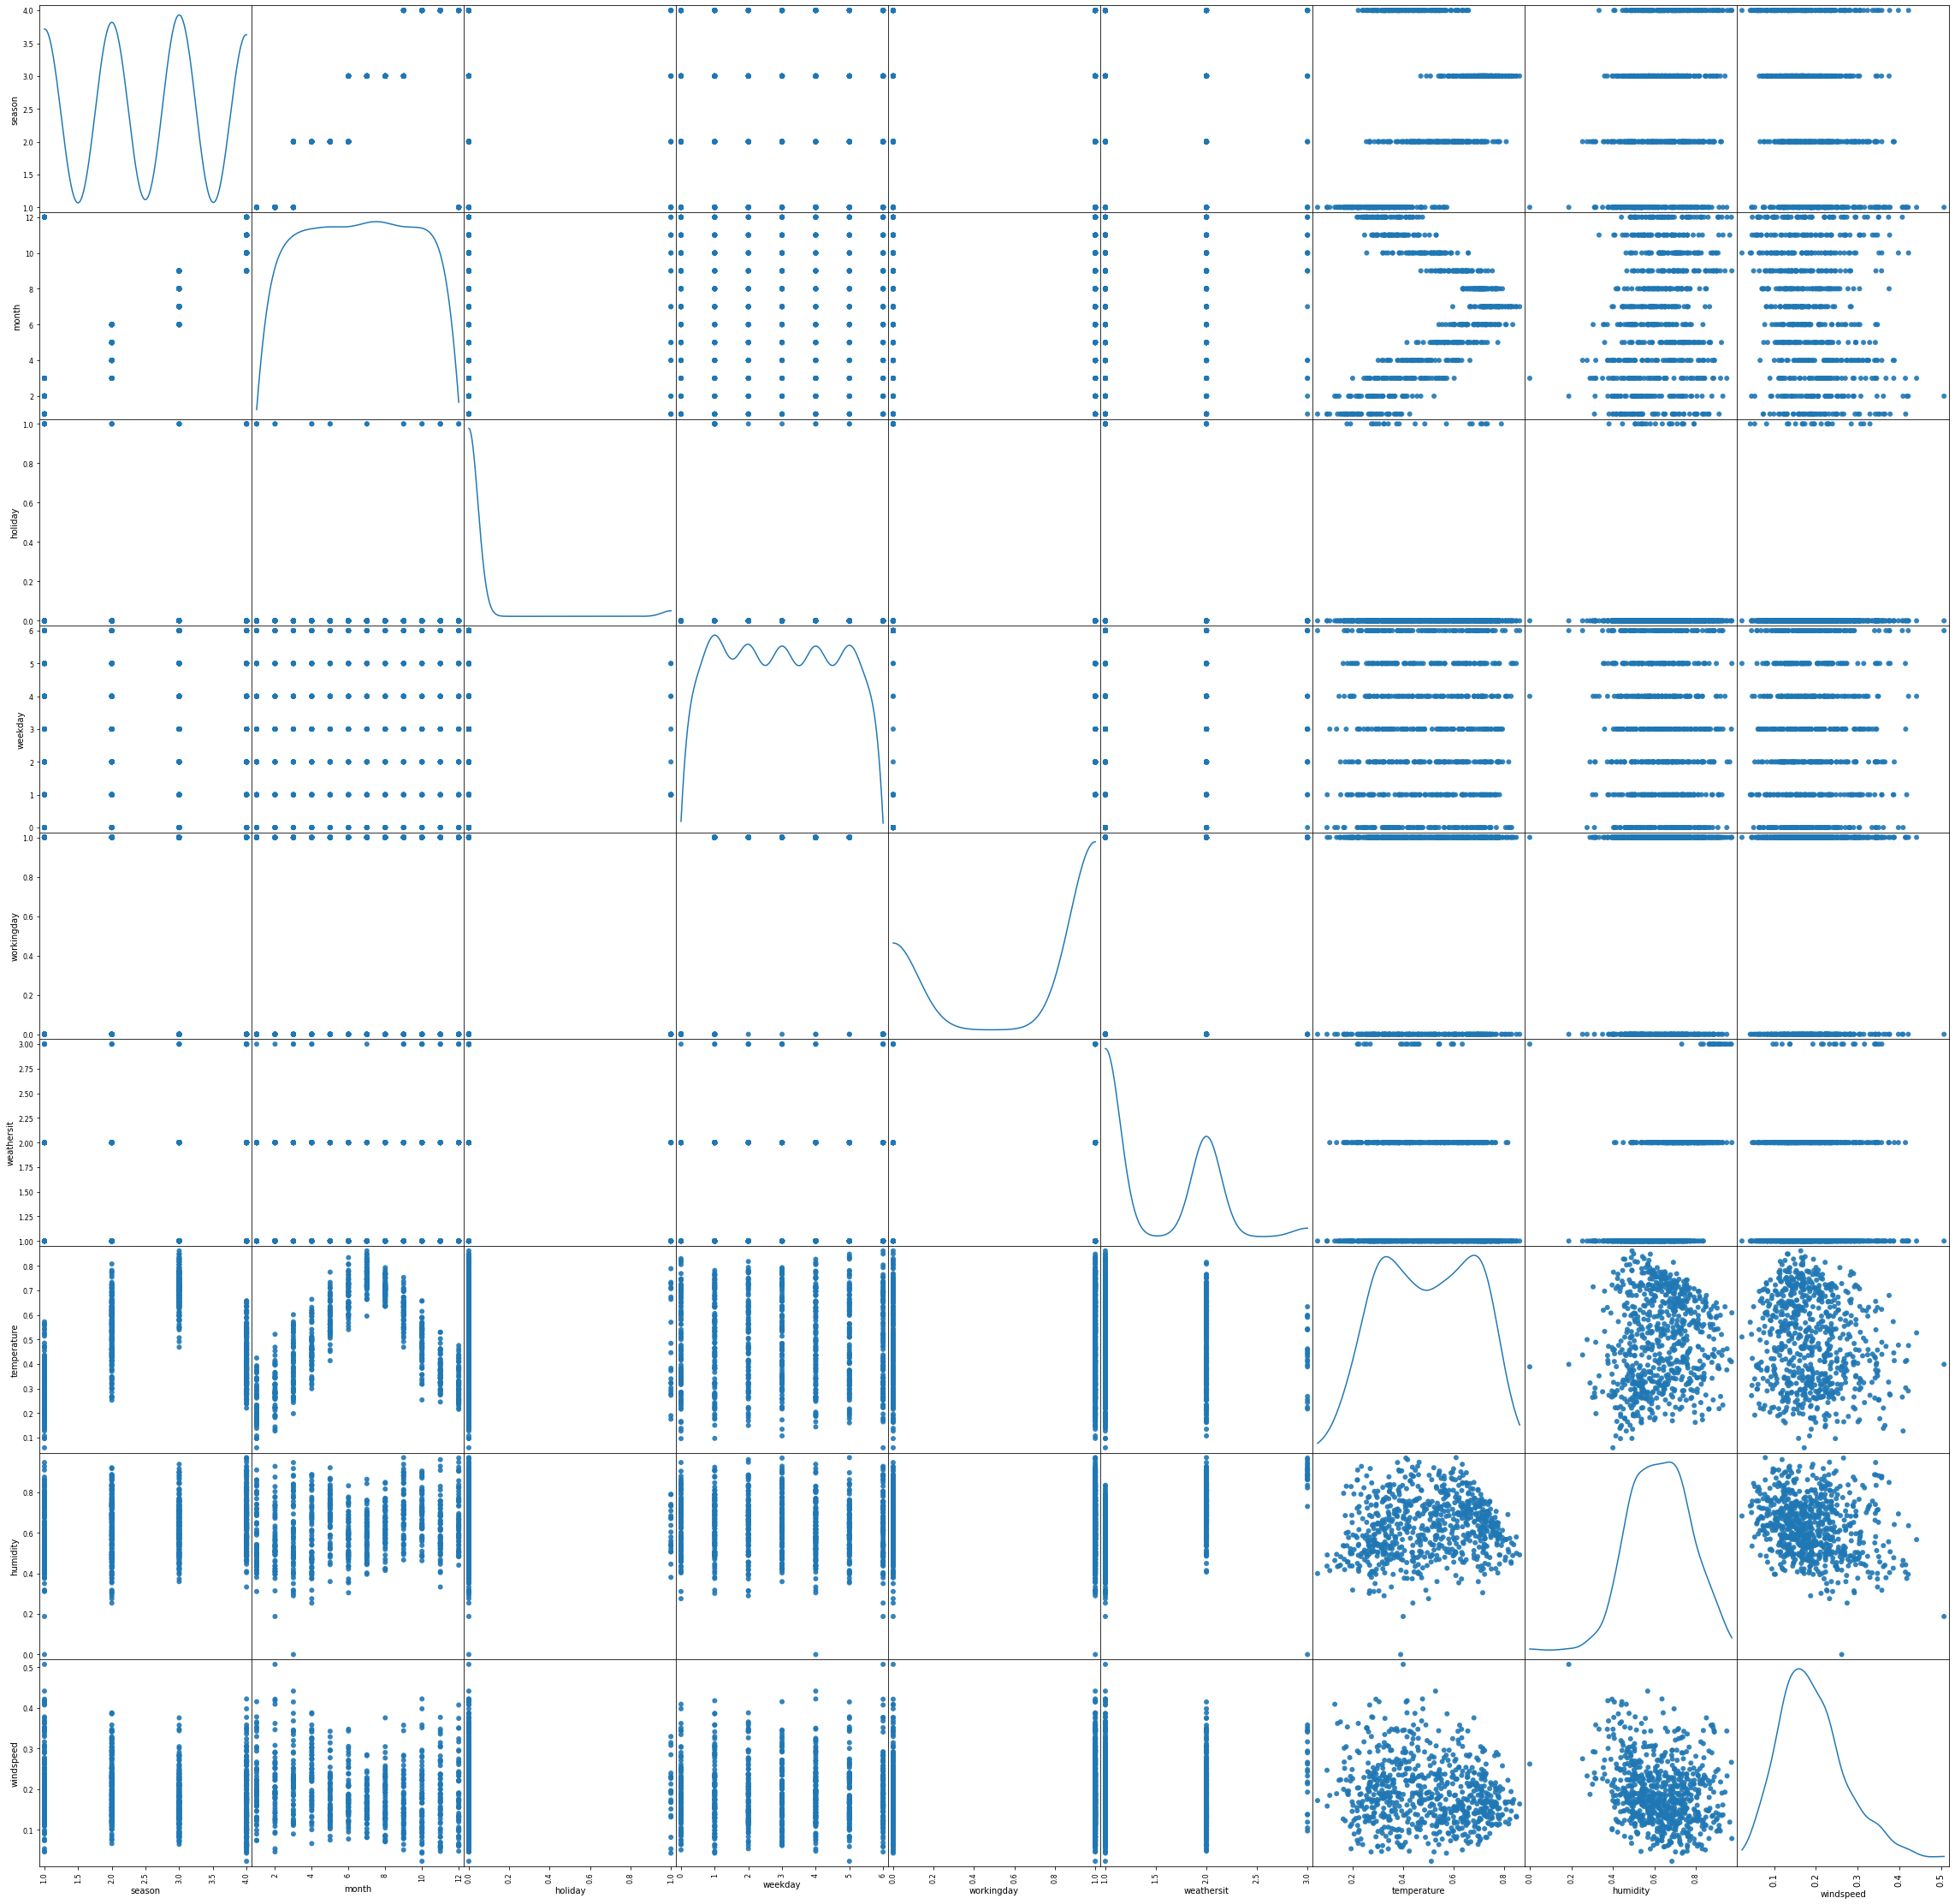

In [70]:
fig = plt.figure()
pd.plotting.scatter_matrix(X,figsize =(40,40),alpha=0.9,diagonal="kde",marker="o");
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

# построить модель и оценить модель
# build model and evalute model

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

print("Training GradientBoostingRegressor...")
tic = time()
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

print("done in {:.2f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(model.score(X_test, y_test)))

Training GradientBoostingRegressor...
done in 0.88s
Test R2 score: 0.57


# PDP

there are four cases for weathersit
weathersit :
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
We can see that there are only values of 1 and 2, that is, the weather is sunny and cloudy, which is in line with our common sense.
The steeper the image, the more influence the feature has on the result. So let's continue to observe "temperature", "humidity" and "wind speed".

есть четыре случая для погоды
погода:
1: ясно, небольшая облачность, переменная облачность, переменная облачность
2: Туман + Облачно, Туман + Разорванные облака, Туман + Немного облаков, Туман
3: Слабый снег, Слабый дождь + Гроза + Рассеянные облака, Слабый дождь + Рассеянные облака
4: Сильный дождь + ледяные поддоны + гроза + туман, снег + туман
Мы видим, что для weathersit есть только значения 1 и 2, то есть погода солнечная или облачная, что соответствует нашему здравому смыслу.
Чем круче изображение, тем большее влияние признаков оказывает на результат. Так что продолжим наблюдать за «температурой», «влажностью» и «скоростью ветра».



Computing partial dependence plots...
done in 0.943s


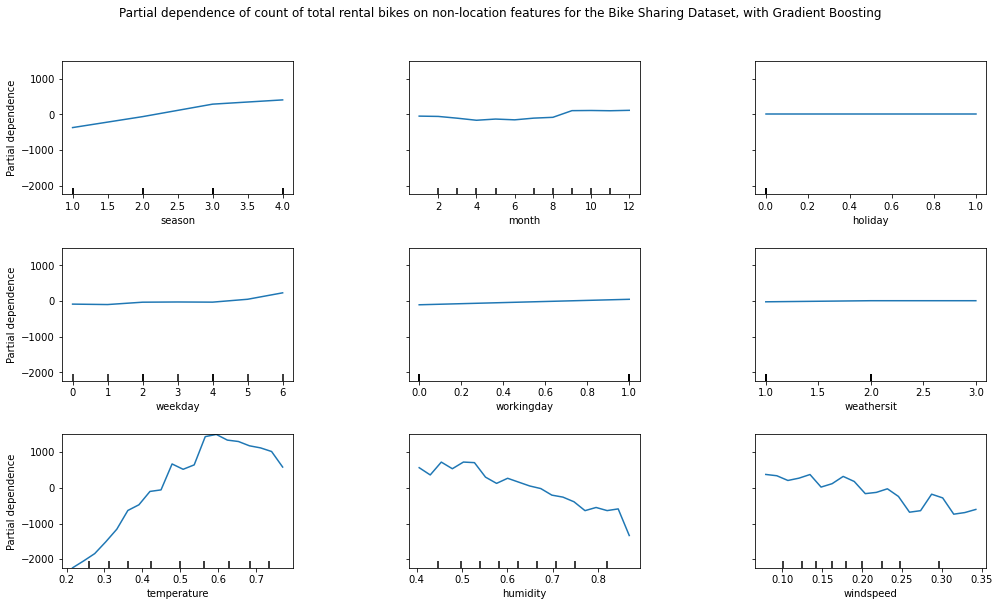

In [72]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

print('Computing partial dependence plots...')
tic = time()
features = X_train.columns
plot_partial_dependence(est, X_train, features,
                        n_jobs=3, grid_resolution=20)
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.set_size_inches(14, 9)
fig.suptitle('Partial dependence of count of total rental bikes on non-location features for the Bike Sharing Dataset, with Gradient Boosting')
fig.subplots_adjust(wspace=0.5, hspace=0.4)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

In [73]:
ice_df = ice(data = X_train, column = 'temperature', predict = est.predict, num_grid_points=10)

In [74]:
ice_df.head

<bound method NDFrame.head of data_temperature     0.059130     0.096522     0.097391     0.107500  \
season                    1.0          1.0          1.0          1.0   
month                     1.0          1.0          1.0          1.0   
holiday                   0.0          0.0          0.0          0.0   
weekday                   6.0          0.0          1.0          3.0   
workingday                0.0          0.0          1.0          1.0   
weathersit                1.0          1.0          1.0          2.0   
humidity             0.400000     0.436522     0.491739     0.414583   
windspeed            0.171970     0.246600     0.158330     0.184700   
temperature                                                            
0.059130          1487.451044  1399.641827  1721.022528  1960.776400   
0.265833          2248.643509  1842.470602  2880.380066  3068.662723   
0.321723          2643.641141  2178.023818  3547.701734  3543.633322   
0.383889          4162.301498  358

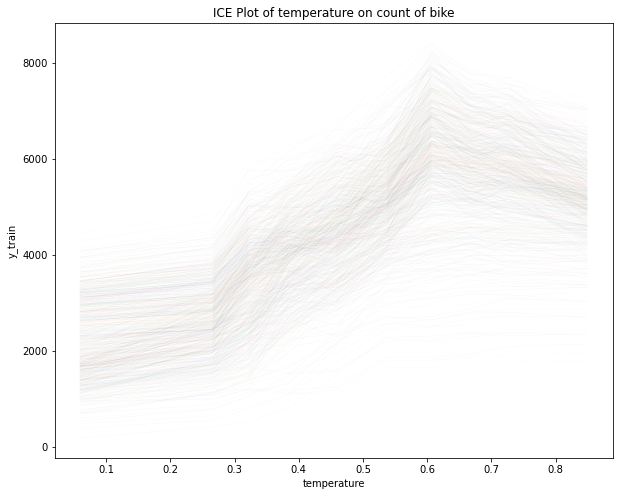

In [75]:
plt.rcParams['figure.figsize'] = 10,8
ice_plot(ice_df, linewidth = .15, cmap=PuOr, alpha = 0.1)

plt.ylabel('y_train')
plt.xlabel('temperature')
plt.title('ICE Plot of temperature on count of bike')
plt.show()

# ICE

Text(0.5, 1.0, 'ICE Plot of temperature on count of bike')

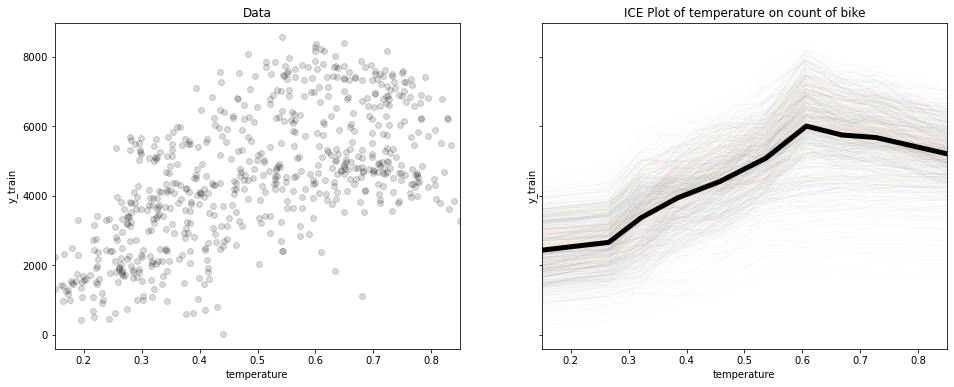

In [76]:
fig, (data_ax, ice_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))
data_ax.scatter(X_train.temperature, y_train, c='k', alpha=0.15)
data_ax.set_xlim(0.15, 0.85)
data_ax.set_xlabel('temperature')
data_ax.set_ylabel('y_train')
data_ax.set_title('Data')
ice_plot(ice_df, linewidth=0.25, cmap=PuOr, alpha = 0.1, ax = ice_ax , plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
ice_ax.set_xlabel('temperature')
ice_ax.set_ylabel('y_train')
ice_ax.set_title('ICE Plot of temperature on count of bike')